In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage import transform
# display plots in this notebook
%matplotlib inline

import os

# set display defaults
plt.rcParams['figure.figsize'] = (12, 9)        # small images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
data_path = '../evaluation'

# Load classes
classes = ['__background__']
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

In [3]:
import argparse
import os
import sys
import torch
import tqdm
import cv2
import numpy as np
sys.path.append('../detectron2')
sys.path.append('../')

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, default_setup, launch
from detectron2.evaluation import COCOEvaluator, verify_results

from utils import mkdir, save_features
from extract_utils import get_image_blob
from bua.caffe import add_bottom_up_attention_config
from bua.caffe.modeling.layers.nms import nms
from bua.d2 import add_attribute_config

In [6]:
# Change the config file name when you want to use other model.
# Note: change the mode to fit your model when you change the config file name.
config_file = '../configs/caffe/test-caffe-r152.yaml'
mode = "caffe"
# config_file = '../configs/d2/d2-X-152-c4.yaml'
# mode = "d2"



cfg = get_cfg()
if mode == "caffe":
    add_bottom_up_attention_config(cfg, True)
elif mode == "d2":
    add_attribute_config(cfg)
else:
    raise Exception("detection model not supported: {}".format(mode))
cfg.merge_from_file(config_file)
cfg.merge_from_list(['MODEL.BUA.EXTRACT_FEATS',True])
cfg.freeze()

Config '../configs/caffe/test-caffe-r152.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [7]:
MIN_BOXES = 10
MAX_BOXES = 20
CONF_THRESH = 0.4
# 
model = DefaultTrainer.build_model(cfg)
DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
    '../'+cfg.MODEL.WEIGHTS, resume=True
)
model.eval()

ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.
ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.
ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


GeneralizedBUARCNN(
  (backbone): ResNet(
    (stem): BUABasicStemv2(
      (norm): FrozenBatchNorm2d(num_features=3, eps=2e-05)
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=2e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlockv2(
        (shortcut): Conv2dv2(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv1): Conv2dv2(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv2): Conv2dv2(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=2e-05)
        )
        (conv3): Conv2dv2(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=2e-05)
        )
        (norm): FrozenBatchNorm2d(num_features=64, eps=2e-05)
      )
      (1): BottleneckBlockv2(
        (conv1): Conv2dv2(25

In [8]:
def model_inference(model, batched_inputs, mode):
    if mode == "caffe":
        return model(batched_inputs)
    elif mode == "d2":
        images = model.preprocess_image(batched_inputs)
        features = model.backbone(images.tensor)
    
        if model.proposal_generator:
            proposals, _ = model.proposal_generator(images, features, None)
        else:
            assert "proposals" in batched_inputs[0]
            proposals = [x["proposals"].to(model.device) for x in batched_inputs]

        return model.roi_heads(images, features, proposals, None)
    else:
        raise Exception("detection model not supported: {}".format(mode))


/home/arch/Works/bottom-up-attention.pytorch/.venv/lib/python3.9/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([191,  35,  23, 172,  85,   0, 166, 141, 127, 200, 167,  50,  94,  20,
        147, 137,  25,  16, 151, 170])
boxes=20


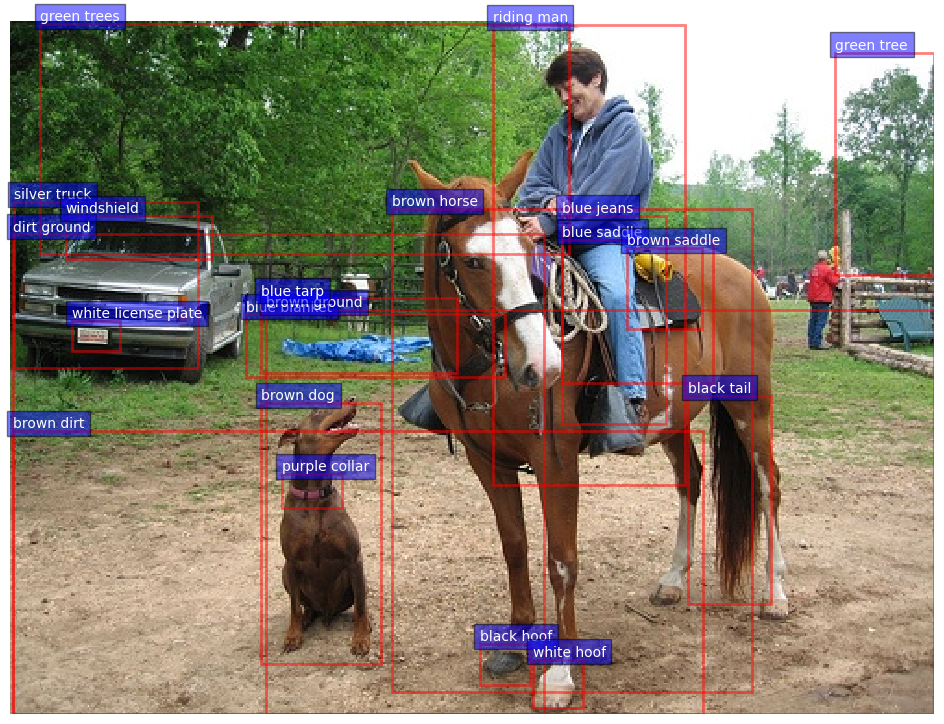

In [9]:
im_file = '../datasets/demo/004545.jpg'

im = cv2.imread(im_file)
dataset_dict = get_image_blob(im, cfg.MODEL.PIXEL_MEAN)

with torch.set_grad_enabled(False):
    boxes, scores, features_pooled, attr_scores = model_inference(model,[dataset_dict],mode)

dets = boxes[0].tensor.cpu() / dataset_dict['im_scale']
scores = scores[0].cpu()
feats = features_pooled[0].cpu()
attr_scores = attr_scores[0].cpu()

max_conf = torch.zeros((scores.shape[0])).to(scores.device)
for cls_ind in range(1, scores.shape[1]):
        cls_scores = scores[:, cls_ind]
        keep = nms(dets, cls_scores, 0.3)
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep],
                                    cls_scores[keep],
                                    max_conf[keep])
            
keep_boxes = torch.nonzero(max_conf >= CONF_THRESH).flatten()
if len(keep_boxes) < MIN_BOXES:
    keep_boxes = torch.argsort(max_conf, descending=True)[:MIN_BOXES]
elif len(keep_boxes) > MAX_BOXES:
    keep_boxes = torch.argsort(max_conf, descending=True)[:MAX_BOXES]

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(im)

boxes = dets[keep_boxes].numpy()
objects = np.argmax(scores[keep_boxes].numpy()[:,1:], axis=1)
attr_thresh = 0.1
attr = np.argmax(attr_scores[keep_boxes].numpy()[:,1:], axis=1)
attr_conf = np.max(attr_scores[keep_boxes].numpy()[:,1:], axis=1)
print(keep_boxes)
for i in range(len(keep_boxes)):
    bbox = boxes[i]
    if bbox[0] == 0:
        bbox[0] = 1
    if bbox[1] == 0:
        bbox[1] = 1
    
    if mode == "caffe":
        cls = classes[objects[i]+1]  # caffe +2
        if attr_conf[i] > attr_thresh:
            cls = attributes[attr[i]+1] + " " + cls   #  caffe +2
    elif mode == "d2":
        cls = classes[objects[i]+2]  # d2 +2
        if attr_conf[i] > attr_thresh:
            cls = attributes[attr[i]+2] + " " + cls   # d2 +2
    else:
        raise Exception("detection model not supported: {}".format(mode))
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                '%s' % (cls),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=10, color='white')
print('boxes={}'.format(len(keep_boxes)))